# Day 3: LangGraph & Advanced Agent Patterns

## Building Multi-Agent Systems with Graph-Based Workflows

Welcome to Day 3! Today we'll explore **LangGraph**, a powerful framework for building sophisticated, stateful agent workflows that support loops, complex branching, and multi-agent coordination.

---

## Learning Objectives

By the end of Day 3, you will be able to:

1. **Design and implement graph-based agent workflows**: Structure agent logic as graphs of nodes and edges rather than linear chains
2. **Create multi-agent coordination systems**: Build agents with specialized sub-agents that communicate and hand off tasks
3. **Implement human-in-the-loop checkpoints**: Insert approval gates where human input is required
4. **Build complex workflows**: Create parallel processing, conditional routing, and self-healing systems

---

## Prerequisites

- Completion of Day 2 (LangChain fundamentals)
- Understanding of agent concepts and tool usage
- Familiarity with async programming (helpful but not required)

---

## What We'll Build

- **Research Assistant**: Multi-agent system with research, writing, and quality control
- **Self-Healing Workflow**: Agent that automatically recovers from errors
- **Human-Supervised Pipeline**: Workflow with approval checkpoints
- **Parallel Processing System**: Concurrent data gathering and analysis

## Setup

In [1]:
%%capture --no-stderr
%pip install langgraph langchain langchain-openai langchain-community python-dotenv tavily-python

In [2]:
# API Key Setup
import os
from getpass import getpass

keys = ["OPENAI_API_KEY", "TAVILY_API_KEY"]
for key in keys:
    if key not in os.environ:
        if key == "TAVILY_API_KEY":
            value = getpass(f"Enter your {key} (optional for web search): ")
            if value:
                os.environ[key] = value
        else:
            os.environ[key] = getpass(f"Enter your {key}: ")

print("API keys configured")

Enter your OPENAI_API_KEY: ··········
Enter your TAVILY_API_KEY (optional for web search): ··········
API keys configured


In [3]:
# Core imports
import os
import json
import time
import asyncio
from datetime import datetime
from typing import TypedDict, List, Dict, Any, Optional, Annotated
from getpass import getpass

# LangGraph and LangChain
from langgraph.graph import StateGraph, END
from langgraph.graph import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.globals import set_debug, set_verbose

print("Imports successful!")

Imports successful!


## LangGraph vs LangChain: Key Differences

Building on Day 2's LangChain foundation, LangGraph extends these capabilities:

| Feature | LangChain | LangGraph |
|---------|-----------|----------|
| **Structure** | Linear chains | Graph workflows |
| **Loops** | Not supported | Full cycle support |
| **State** | Limited | Rich, persistent |
| **Routing** | Basic | Conditional logic |
| **Error Handling** | Manual | Self-healing |
| **Human Oversight** | Custom | Built-in checkpoints |

### Why LangGraph?

- **Cyclical workflows**: Agents can loop, retry, and self-correct
- **Dynamic routing**: Decisions based on runtime state
- **Persistent state**: Context maintained across operations
- **Multi-agent systems**: Native coordination support
- **Human-in-the-loop**: Built-in approval gates

## Model Initialization for LangGraph

Similar to Day 2, we can initialize different models for our agents:

In [4]:
# Initialize models like in Day 2
openai_llm = init_chat_model(model="gpt-4.1-mini", model_provider="openai")

# Test basic functionality
response = openai_llm.invoke("What is LangGraph?")
print(f"Model response: {response.content[:100]}...")
print(f"Token usage: {response.usage_metadata}")

Model response: LangGraph is a framework or tool designed to represent, analyze, or process language-related data us...
Token usage: {'input_tokens': 12, 'output_tokens': 197, 'total_tokens': 209, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## Debugging LangGraph Workflows

LangGraph workflows can be complex, so proper debugging is essential:

In [5]:
# Enable debugging (from Day 2)
set_debug(True)
set_verbose(True)

# Test with debugging enabled
debug_response = openai_llm.invoke("Hello LangGraph")
print(f"Response: {debug_response.content}")

# Disable for cleaner output
set_debug(False)
set_verbose(False)
print("Debugging disabled for cleaner output")

[llm/start] [llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Hello LangGraph"
  ]
}
[llm/end] [llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Hello! How can I assist you with LangGraph today?",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "Hello! How can I assist you with LangGraph today?",
            "additional_kwargs": {
              "refusal": null
            },
            "response_metadata": {
              "token_usage": {
                "completion_tokens": 12,
                "prompt_tokens": 10,
                "total_tokens": 22,
                "completion_tokens

## Core LangGraph Concepts

### Nodes and Edges

- **Nodes**: Units of computation (functions, LLM calls, tool usage)
- **Edges**: Flow control between nodes
- **Conditional Edges**: Dynamic routing based on state

### State Management

- **TypedDict**: Structure for workflow state
- **Persistence**: Automatic state checkpointing
- **Updates**: How nodes modify shared state

In [6]:
# Define a basic state structure
class WorkflowState(TypedDict):
    """State that flows through our workflow"""
    messages: Annotated[List[BaseMessage], add_messages]
    current_step: str
    step_count: int
    results: Dict[str, Any]
    error_count: int

# Simple node function
def greeting_node(state: WorkflowState) -> WorkflowState:
    """Process initial greeting"""
    print(f"Processing step: {state['current_step']}")

    response = openai_llm.invoke(
        f"Provide a brief, helpful response to: {state['messages'][-1].content}"
    )

    return {
        **state,
        "messages": state["messages"] + [response],
        "current_step": "greeting_complete",
        "step_count": state["step_count"] + 1,
        "results": {**state["results"], "greeting": response.content}
    }

print("Basic workflow components defined")

Basic workflow components defined


In [7]:
# Build a simple workflow
def build_simple_workflow():
    workflow = StateGraph(WorkflowState)

    workflow.add_node("greeting", greeting_node)
    workflow.add_edge("greeting", END)
    workflow.set_entry_point("greeting")

    return workflow.compile()

# Test the workflow
simple_workflow = build_simple_workflow()

We can also visualize the workflow we just created:

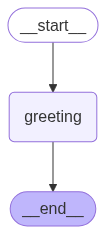

In [8]:
from IPython.display import Image, display
# Display as PNG
png_graph = simple_workflow.get_graph().draw_mermaid_png()
display(Image(png_graph))

Now let's test the workflow:

In [9]:
# Run with test input
initial_state = {
    "messages": [HumanMessage(content="Hello! I want to learn about LangGraph.")],
    "current_step": "start",
    "step_count": 0,
    "results": {},
    "error_count": 0
}

result = simple_workflow.invoke(initial_state)
print(f"\nWorkflow completed in {result['step_count']} steps")
print(f"Final response: {result['results']['greeting']}...")

Processing step: start

Workflow completed in 1 steps
Final response: Hello! LangGraph is a tool or framework designed to help with building and managing language-related graph data, often used in natural language processing or knowledge representation. If you'd like, I can provide more detailed information or resources to help you get started!...


## Tools in LangGraph

Building on Day 2's tool concepts, let's create practical tools for our agents:

In [10]:
# Define practical tools
@tool
def calculate(expression: str) -> str:
    """Safely evaluate mathematical expressions"""
    try:
        # Simple calculator for basic operations
        allowed_chars = set('0123456789+-*/.()')
        if all(c in allowed_chars or c.isspace() for c in expression):
            result = eval(expression)
            return f"Result: {result}"
        else:
            return "Error: Invalid characters in expression"
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def search_web(query: str) -> str:
    """Search the web for information"""
    if "TAVILY_API_KEY" not in os.environ:
        return "Web search unavailable (no Tavily API key)"

    try:
        search = TavilySearchResults(max_results=3)
        results = search.invoke(query)
        if results:
            return f"Search results for '{query}': {results[:200]}..."
        return "No results found"
    except Exception as e:
        return f"Search error: {str(e)}"

# Test tools
print(calculate.invoke({"expression": "15 * 8 + 12"}))
print(search_web.invoke({"query": "LangGraph tutorial"})[:50])

Result: 132


/tmp/ipython-input-2650068758.py:23: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=3)


Search results for 'LangGraph tutorial': [{'title'


## ReAct Agent with LangGraph

Let's build a ReAct agent using LangGraph's prebuilt components:

In [11]:
# Create ReAct agent with tools
tools = [calculate, search_web]
react_agent = create_react_agent(model=openai_llm, tools=tools)

# Test the agent
result = react_agent.invoke({
    "messages": [HumanMessage(content="What is 25 * 16, and can you find information about LangGraph?")]
})

print("Agent conversation:")
for message in result["messages"]:
    if hasattr(message, 'content') and message.content:
        print(f"{type(message).__name__}: {message.content[:100]}...")
    elif hasattr(message, 'name'):
        print(f"Tool Result ({message.name}): {message.content[:50]}...")

Agent conversation:
HumanMessage: What is 25 * 16, and can you find information about LangGraph?...
Tool Result (None): ...
ToolMessage: Result: 400...
ToolMessage: Search results for 'LangGraph': [{'title': 'What is LangGraph? - IBM', 'url': 'https://www.ibm.com/t...
AIMessage: The result of 25 * 16 is 400.

Regarding LangGraph, it is an open-source AI agent framework created ...


## Streaming in LangGraph

LangGraph supports streaming just like the models in Day 2:

In [12]:
# Streaming workflow execution
print("Streaming agent execution:")
for chunk in react_agent.stream({
    "messages": [HumanMessage(content="Calculate 12 * 15 and explain the result")]
}):
    if 'agent' in chunk:
        message = chunk['agent']['messages'][-1]
        if hasattr(message, 'content') and message.content:
            print(f"Agent: {message.content}")
    elif 'tools' in chunk:
        message = chunk['tools']['messages'][-1]
        print(f"Tool: {message.content}")
    print("---")

Streaming agent execution:
---
Tool: Result: 180
---
Agent: The result of multiplying 12 by 15 is 180. This comes from the fact that multiplication is essentially repeated addition; adding 12 together 15 times (or vice versa) gives 180.
---


## Memory and Checkpointing

LangGraph's memory system builds on Day 2's concepts with automatic checkpointing:

In [14]:
# Create agent with memory
agent_with_memory = create_react_agent(
    model=openai_llm,
    tools=tools,
    checkpointer=MemorySaver()
)

# Configuration for thread management
config = {"configurable": {"thread_id": "lesson_3_thread"}}

# First interaction
result1 = agent_with_memory.invoke({
    "messages": [HumanMessage(content="My name is Alex. Calculate 20 * 5 for me.")]
}, config)

print(f"First result: {result1['messages'][-1].content}...")

# Second interaction (should remember name)
result2 = agent_with_memory.invoke({
    "messages": [HumanMessage(content="What's my name, and what was the last calculation?")]
}, config)

print(f"Second result: {result2['messages'][-1].content}...")

# Check memory state
memory_state = agent_with_memory.checkpointer.get(config)
print(f"\nMemory contains {len(memory_state['channel_values']['messages'])} messages")

First result: Hi Alex! The result of 20 multiplied by 5 is 100. If you need any more calculations or assistance, feel free to ask!...
Second result: Your name is Alex. The last calculation was 20 multiplied by 5, which equals 100. If you need anything else, just let me know!...

Memory contains 6 messages


## Token Tracking in LangGraph

Building on Day 2's cost analysis, let's track tokens across workflow execution:

In [15]:
# Enhanced state with token tracking
class TokenTrackingState(WorkflowState):
    total_tokens: int
    total_cost: float
    token_details: List[Dict[str, Any]]

def calculate_cost(usage_metadata: Dict[str, Any]) -> float:
    """Calculate cost based on token usage (GPT-4o-mini pricing)"""
    input_cost = 0.15 / 1_000_000  # $0.15 per 1M input tokens
    output_cost = 0.60 / 1_000_000  # $0.60 per 1M output tokens

    input_tokens = usage_metadata.get('input_tokens', 0)
    output_tokens = usage_metadata.get('output_tokens', 0)

    return (input_tokens * input_cost) + (output_tokens * output_cost)

def tracking_node(state: TokenTrackingState) -> TokenTrackingState:
    """Node that tracks token usage"""
    response = openai_llm.invoke(
        f"Provide a helpful response to: {state['messages'][-1].content}"
    )

    # Extract token usage
    usage = response.usage_metadata
    cost = calculate_cost(usage)

    return {
        **state,
        "messages": state["messages"] + [response],
        "current_step": "tracking_complete",
        "step_count": state["step_count"] + 1,
        "total_tokens": state["total_tokens"] + usage.get('total_tokens', 0),
        "total_cost": state["total_cost"] + cost,
        "token_details": state["token_details"] + [{
            "step": state["step_count"] + 1,
            "tokens": usage,
            "cost": cost
        }]
    }

# Test token tracking
tracking_state = {
    "messages": [HumanMessage(content="Explain LangGraph in simple terms")],
    "current_step": "start",
    "step_count": 0,
    "results": {},
    "error_count": 0,
    "total_tokens": 0,
    "total_cost": 0.0,
    "token_details": []
}

result = tracking_node(tracking_state)
print(f"Total tokens used: {result['total_tokens']}")
print(f"Total cost: ${result['total_cost']:.6f}")
print(f"Response: {result['messages'][-1].content}...")

Total tokens used: 105
Total cost: $0.000054
Response: Sure! LangGraph is a tool that helps connect and organize pieces of information in a way that’s easy to understand and use. Think of it like a map for ideas and concepts, where related things are linked together. This makes it easier to see how different ideas connect, find important information quickly, and build on knowledge step-by-step. It’s especially useful for handling complex topics by breaking them down into smaller, connected parts....


## Async Patterns in LangGraph

LangGraph supports async execution like the models in Day 2:

In [16]:
# Async workflow execution
async def async_workflow_test():
    """Test async workflow execution"""
    start_time = time.time()

    # Multiple async invocations
    tasks = [
        react_agent.ainvoke({
            "messages": [HumanMessage(content=f"Calculate {i} * {i+1}")]
        }) for i in range(3, 6)
    ]

    results = await asyncio.gather(*tasks)
    end_time = time.time()

    print(f"Async execution completed in {end_time - start_time:.2f} seconds")
    for i, result in enumerate(results):
        final_message = result['messages'][-1].content
        print(f"Task {i+1}: {final_message[:50]}...")

# Run async test
await async_workflow_test()

Async execution completed in 2.33 seconds
Task 1: The result of 3 multiplied by 4 is 12....
Task 2: The result of 4 multiplied by 5 is 20....
Task 3: The result of 5 multiplied by 6 is 30....


## Multi-Agent Coordination

Now let's build a practical multi-agent system with real LLM interactions:

In [17]:
# Multi-agent state
class MultiAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    research_results: str
    draft_content: str
    final_output: str
    current_agent: str
    quality_score: float
    retry_count: int
    total_tokens: int
    total_cost: float

def research_agent(state: MultiAgentState) -> MultiAgentState:
    """Research agent that gathers information"""
    print("Research Agent: Gathering information...")

    # Use search tool or LLM for research
    if "TAVILY_API_KEY" in os.environ:
        search_results = search_web.invoke({"query": state["task"]})
        research_prompt = f"Based on this search: {search_results}\n\nProvide 3 key research points about: {state['task']}"
    else:
        research_prompt = f"Provide 3 key research points about: {state['task']}"

    response = openai_llm.invoke(research_prompt)

    # Track tokens
    usage = response.usage_metadata
    cost = calculate_cost(usage)

    return {
        **state,
        "research_results": response.content,
        "current_agent": "research_complete",
        "messages": state["messages"] + [AIMessage(content=f"Research completed: {response.content[:100]}...")],
        "total_tokens": state["total_tokens"] + usage.get('total_tokens', 0),
        "total_cost": state["total_cost"] + cost
    }

def writing_agent(state: MultiAgentState) -> MultiAgentState:
    """Writing agent that creates content"""
    print("Writing Agent: Creating content...")

    writing_prompt = f"""
    Task: {state['task']}
    Research: {state['research_results']}

    Write a clear, informative article (200-300 words) based on this research.
    """

    response = openai_llm.invoke(writing_prompt)

    # Track tokens
    usage = response.usage_metadata
    cost = calculate_cost(usage)

    return {
        **state,
        "draft_content": response.content,
        "current_agent": "writing_complete",
        "messages": state["messages"] + [AIMessage(content="Draft article created")],
        "total_tokens": state["total_tokens"] + usage.get('total_tokens', 0),
        "total_cost": state["total_cost"] + cost
    }

def quality_agent(state: MultiAgentState) -> MultiAgentState:
    """Quality agent that evaluates content"""
    print("Quality Agent: Evaluating content...")

    evaluation_prompt = f"""
    Evaluate this article on a scale of 1-10:
    {state['draft_content']}

    Consider: clarity, completeness, structure. Respond with just a number (1-10).
    """

    response = openai_llm.invoke(evaluation_prompt)

    try:
        score = float(response.content.strip())
    except:
        score = 7.0  # Default score if parsing fails

    # Track tokens
    usage = response.usage_metadata
    cost = calculate_cost(usage)

    if score >= 7.0:
        current_agent = "quality_approved"
        final_output = state["draft_content"]
        print(f"Content approved with score: {score}")
    else:
        current_agent = "quality_revision_needed"
        final_output = ""
        print(f"Revision needed, score: {score}")

    return {
        **state,
        "quality_score": score,
        "final_output": final_output,
        "current_agent": current_agent,
        "messages": state["messages"] + [AIMessage(content=f"Quality score: {score}")],
        "total_tokens": state["total_tokens"] + usage.get('total_tokens', 0),
        "total_cost": state["total_cost"] + cost
    }

print("Multi-agent system defined")

Multi-agent system defined


In [18]:
# Router for multi-agent coordination
def agent_router(state: MultiAgentState) -> str:
    """Route between agents based on current state"""
    current = state["current_agent"]
    retry_count = state.get("retry_count", 0)

    if current == "start":
        return "research_agent"
    elif current == "research_complete":
        return "writing_agent"
    elif current == "writing_complete":
        return "quality_agent"
    elif current == "quality_approved":
        return END
    elif current == "quality_revision_needed":
        if retry_count < 2:
            return "writing_agent"
        else:
            return END
    else:
        return END

# Build the multi-agent workflow
def build_multi_agent_workflow():
    workflow = StateGraph(MultiAgentState)

    workflow.add_node("research_agent", research_agent)
    workflow.add_node("writing_agent", writing_agent)
    workflow.add_node("quality_agent", quality_agent)

    workflow.add_conditional_edges(
        "research_agent",
        agent_router,
        {
            "writing_agent": "writing_agent",
            END: END
        }
    )

    workflow.add_conditional_edges(
        "writing_agent",
        agent_router,
        {
            "quality_agent": "quality_agent",
            END: END
        }
    )

    workflow.add_conditional_edges(
        "quality_agent",
        agent_router,
        {
            "writing_agent": "writing_agent",
            END: END
        }
    )

    workflow.set_entry_point("research_agent")
    return workflow.compile(checkpointer=MemorySaver()) # Add memory here

# Test the multi-agent system
multi_agent_workflow = build_multi_agent_workflow()

Now let's visualize it:

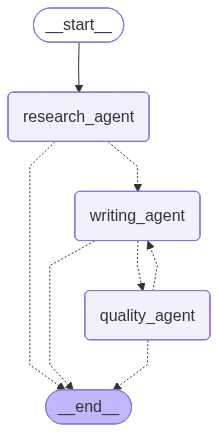

In [19]:
display(Image(multi_agent_workflow.get_graph().draw_mermaid_png()))

In [20]:
initial_state = {
    "messages": [HumanMessage(content="Create an article about Python programming")],
    "task": "Python programming fundamentals",
    "research_results": "",
    "draft_content": "",
    "final_output": "",
    "current_agent": "start",
    "quality_score": 0.0,
    "retry_count": 0,
    "total_tokens": 0,
    "total_cost": 0.0
}

multi_agent_config = {"configurable": {"thread_id": "lesson_3_thread_01"}}

result = multi_agent_workflow.invoke(initial_state, multi_agent_config)

print(f"\nWorkflow completed!")
print(f"Quality score: {result['quality_score']}")
print(f"Total tokens: {result['total_tokens']}")
print(f"Total cost: ${result['total_cost']:.6f}")
print(f"\nFinal article:\n{result['final_output']}...")

Research Agent: Gathering information...
Writing Agent: Creating content...
Quality Agent: Evaluating content...
Content approved with score: 8.0

Workflow completed!
Quality score: 8.0
Total tokens: 2568
Total cost: $0.000693

Final article:
**Understanding Python Programming Fundamentals: A Beginner’s Guide**

Python has become one of the most popular programming languages worldwide, largely due to its simplicity and readability. For beginners, grasping the fundamentals of Python is essential to start writing effective and efficient code. Three core areas form the foundation of Python programming: core concepts and syntax, control flow and data structures, and functions with modular programming.

At the heart of Python is its clear and intuitive syntax. Python emphasizes readability, allowing programmers to express ideas in fewer lines compared to many other languages. Key concepts to master include variables, which store data values, and data types such as strings (text), numbers (i

## Error Handling and Self-Healing

LangGraph workflows can recover from errors automatically:

In [21]:
# Error handling state
class ErrorHandlingState(TypedDict):
    task: str
    attempts: int
    max_attempts: int
    errors: List[str]
    success: bool
    result: str

def risky_operation_node(state: ErrorHandlingState) -> ErrorHandlingState:
    """Simulates an operation that might fail"""
    print(f"Attempt {state['attempts'] + 1} of {state['max_attempts']}")

    # Simulate random failure
    import random
    if random.random() < 0.6:  # 60% chance of failure
        error_msg = f"Simulated failure on attempt {state['attempts'] + 1}"
        print(f"Error: {error_msg}")

        return {
            **state,
            "attempts": state["attempts"] + 1,
            "errors": state["errors"] + [error_msg],
            "success": False
        }
    else:
        print("Operation succeeded!")
        response = openai_llm.invoke(f"Task completed successfully: {state['task']}")

        return {
            **state,
            "attempts": state["attempts"] + 1,
            "success": True,
            "result": response.content
        }

def error_recovery_router(state: ErrorHandlingState) -> str:
    """Decide whether to retry or give up"""
    if state["success"]:
        return END
    elif state["attempts"] < state["max_attempts"]:
        print("Retrying operation...")
        return "risky_operation"
    else:
        print("Max attempts reached, giving up")
        return END

# Build error handling workflow
def build_error_handling_workflow():
    workflow = StateGraph(ErrorHandlingState)

    workflow.add_node("risky_operation", risky_operation_node)

    workflow.add_conditional_edges(
        "risky_operation",
        error_recovery_router,
        {
            "risky_operation": "risky_operation",
            END: END
        }
    )

    workflow.set_entry_point("risky_operation")
    return workflow.compile(checkpointer=MemorySaver())

# Test error handling
error_workflow = build_error_handling_workflow()
error_config = {"configurable": {"thread_id": "lesson_3_errors"}}
error_state = {
    "task": "Process important data",
    "attempts": 0,
    "max_attempts": 3,
    "errors": [],
    "success": False,
    "result": ""
}

error_result = error_workflow.invoke(error_state, error_config)

print(f"\nFinal result:")
print(f"Success: {error_result['success']}")
print(f"Attempts: {error_result['attempts']}")
print(f"Errors: {len(error_result['errors'])}")
if error_result['success']:
    print(f"Result: {error_result['result'][:100]}...")

Attempt 1 of 3
Error: Simulated failure on attempt 1
Retrying operation...
Attempt 2 of 3
Operation succeeded!

Final result:
Success: True
Attempts: 2
Errors: 1
Result: Great to hear that the task was completed successfully! If you need any further assistance or have m...


## Human-in-the-Loop Workflows

LangGraph can pause for human approval using interrupts. In order to use this, you **MUST** have a `checkpointer` configured to use Human in the Loop. Without a checkpointer the graph will be unable to pick up where it left off.

In [22]:
from langgraph.types import interrupt, Command
# Human-in-the-loop example
class HumanLoopState(TypedDict):
    task: str
    proposal: str
    human_approved: Optional[bool]
    human_feedback: str
    final_result: str

def generate_proposal_node(state: HumanLoopState) -> HumanLoopState:
    """Generate a proposal for human review"""
    print("Generating proposal for human review...")

    response = openai_llm.invoke(f"""
    Generate a detailed proposal for this task: {state['task']}
    Include steps, timeline, and potential risks.
    """)

    return {
        "proposal": response.content
    }

def human_review_node(state: HumanLoopState) -> HumanLoopState:
    """Simulate human review (in practice, this would pause for real input)"""
    print("Human review required...")
    print(f"Proposal: {state['proposal'][:400]}...")
    approved = interrupt(
        state["proposal"]
    )
    if approved:
        feedback = "Approved: Proposal looks good, proceed with implementation"
        print("Human approved the proposal")
    else:
        feedback = "Rejected: Please revise the timeline and risk assessment"
        print("Human rejected the proposal")

    return {
        "human_approved": approved,
        "human_feedback": feedback
    }

def execute_task_node(state: HumanLoopState) -> HumanLoopState:
    """Execute the approved task"""
    if state["human_approved"]:
        print("Executing approved task...")
        response = openai_llm.invoke(f"Execute this approved task: {state['task']}")
        result = f"Task completed: {response.content}"
    else:
        result = f"Task cancelled: {state['human_feedback']}"
        print("Task cancelled due to human rejection")

    return {
        "final_result": result
    }

# Build human-in-the-loop workflow
def build_human_loop_workflow():
    workflow = StateGraph(HumanLoopState)

    workflow.add_node("generate_proposal", generate_proposal_node)
    workflow.add_node("human_review", human_review_node)
    workflow.add_node("execute_task", execute_task_node)

    workflow.add_edge("generate_proposal", "human_review")
    workflow.add_edge("human_review", "execute_task")
    workflow.add_edge("execute_task", END)

    workflow.set_entry_point("generate_proposal")
    return workflow.compile(checkpointer=MemorySaver())

# Test human-in-the-loop workflow
human_loop_workflow = build_human_loop_workflow()



Visualize it:

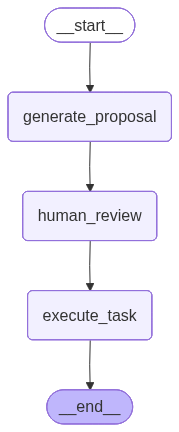

In [23]:
display(Image(human_loop_workflow.get_graph().draw_mermaid_png()))

Now let's test it:

In [24]:
human_state = {
    "task": "Implement new user authentication system",
    "proposal": "",
    "human_approved": None,
    "human_feedback": "",
    "final_result": ""
}
hitl_config = {"configurable": {"thread_id": "lesson_3_hitl"}}
human_result = human_loop_workflow.invoke(human_state, hitl_config)

Generating proposal for human review...
Human review required...
Proposal: Certainly! Below is a detailed proposal for implementing a new user authentication system.

---

# Proposal: Implementation of New User Authentication System

## Objective
To design and implement a secure, scalable, and user-friendly authentication system that improves security measures, supports modern authentication standards, and enhances the overall user experience.

---

## Scope

- User regi...


Now we (the human) make a decision and supply it to our graph to let the process continue from where it left off:

In [25]:
approval_prompt = input("Do you approve this proposal? (y/n) ")
approval = approval_prompt.lower() == "y"
human_result = human_loop_workflow.invoke(Command(resume=approval), hitl_config)

Do you approve this proposal? (y/n) y
Human review required...
Proposal: Certainly! Below is a detailed proposal for implementing a new user authentication system.

---

# Proposal: Implementation of New User Authentication System

## Objective
To design and implement a secure, scalable, and user-friendly authentication system that improves security measures, supports modern authentication standards, and enhances the overall user experience.

---

## Scope

- User regi...
Human approved the proposal
Executing approved task...


In [26]:
print(f"\nWorkflow result:")
print(f"Approved: {human_result['human_approved']}")
print(f"Feedback: {human_result['human_feedback']}")
print(f"Result: {human_result['final_result'][:100]}...")


Workflow result:
Approved: True
Feedback: Approved: Proposal looks good, proceed with implementation
Result: Task completed: Before proceeding, could you please provide more details about the new user authenti...


## Production Considerations

### Key Best Practices

1. **Error Handling**: Always include retry logic and graceful failures
2. **Token Tracking**: Monitor usage and costs across workflow execution  
3. **Debugging**: Use LangChain's debugging tools for troubleshooting
4. **Memory Management**: Implement proper checkpointing for long workflows
5. **Security**: Validate inputs and sanitize outputs
6. **Performance**: Use parallel processing where appropriate
7. **Monitoring**: Track execution times and success rates

### Deployment Patterns

- **Stateless Nodes**: Design nodes to be independent when possible
- **Checkpoint Storage**: Use persistent storage for production checkpoints
- **Rate Limiting**: Implement proper API rate limiting
- **Load Balancing**: Distribute workflow execution across instances
- **Graceful Degradation**: Handle service failures elegantly

## Summary

Today we've covered:

- **LangGraph Fundamentals**: Nodes, edges, and state management
- **Tool Integration**: Building agents with real capabilities
- **Multi-Agent Systems**: Coordinating specialized agents
- **Advanced Patterns**: Parallel processing, error handling, human oversight
- **Production Practices**: Monitoring, debugging, and optimization

### Next Steps

1. **Practice**: Build your own multi-agent workflows
2. **Experiment**: Try different coordination patterns
3. **Optimize**: Focus on performance and cost efficiency
4. **Deploy**: Apply production best practices

### Resources

- [LangGraph Documentation](https://python.langchain.com/docs/langgraph)
- [LangChain Community](https://github.com/langchain-ai/langchain)
- [Example Workflows](https://github.com/langchain-ai/langgraph/tree/main/docs/docs/how-tos)

Happy building with LangGraph!